### Data collection

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import datetime
import requests
import json

#### Data source I: Google BigQuery

In [2]:
# import the official package for Google big query API 
from google.cloud import bigquery

# Set Google Credentials environmental
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="C:/googlequery/jetlearningatusc-6a06108d1fda.json"

# Initiate BigQuery Client
client = bigquery.Client()

In [3]:
# Connect the 2011 outpatient_charges table from bigquery-public-data:medicare dataset

# Only focus on clinic visits data 
apcList = ['0604 - Level 1 Hospital Clinic Visits','0605 - Level 2 Hospital Clinic Visits','0606 - Level 3 Hospital Clinic Visits',
          '0607 - Level 4 Hospital Clinic Visits','0608 - Level 5 Hospital Clinic Visits']

# Uses SQL query language as input

query = """
    SELECT apc,provider_state,outpatient_services,average_total_payments
    FROM `bigquery-public-data.medicare.outpatient_charges_2012`
    WHERE apc IN UNNEST (@apc)
"""
# API request and data importing 

query_params = [
    bigquery.ArrayQueryParameter("apc", "STRING", apcList),
]
job_config = bigquery.QueryJobConfig()
job_config.query_parameters = query_params
query_job = client.query(
    query,
    location="US",
    job_config=job_config,
)

iterator = query_job.result(timeout=30)
rows = list(iterator)

outpatientCharge2011 = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))

In [4]:
outpatientCharge2011.head()

,apc,provider_state,outpatient_services,average_total_payments
0,0604 - Level 1 Hospital Clinic Visits,AK,1679,62.290310
1,0604 - Level 1 Hospital Clinic Visits,AK,561,61.321515
2,0604 - Level 1 Hospital Clinic Visits,AK,169,67.538994
3,0604 - Level 1 Hospital Clinic Visits,AK,1173,62.184467
4,0604 - Level 1 Hospital Clinic Visits,AK,122,62.618852


In [5]:
# Aggregate the data to get state level data

df_avgPayment = outpatientCharge2011['average_total_payments'].groupby(outpatientCharge2011['provider_state']).mean()
df_avgPayment = pd.DataFrame(df_avgPayment)
df_avgPayment = df_avgPayment.reset_index()

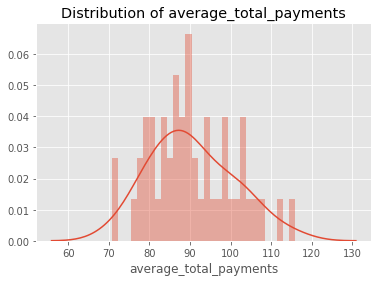

In [6]:
# Import visualization pacakge to see the distribution of the dependent variable

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.style.use('ggplot')
sns.distplot(df_avgPayment['average_total_payments'],kde=True,rug=False,bins=30)
plt.title('Distribution of average_total_payments')

plt.savefig("figure1.png",dpi=100)

#### Data source II: CDC API

CDC: Centers for Disease Control and Prevention

In [7]:
# import sepecific package for CDC API
from sodapy import Socrata

# import credentials to connect to API
with open('C:/Data/Cond/cdcApiToken.json') as f:
    creds = json.loads(f.read())

tokenCDC = creds['app_token']

In [8]:
# Import the interested data 

client = Socrata("chronicdata.cdc.gov", tokenCDC)

results = client.get("nxst-x9p4", where="year = 2011", limit=12000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

In [9]:
# Subset the data to select enacted observations

isEnacted = (results_df['status'] == "Enacted")
results_df = results_df[isEnacted]

In [10]:
# Aggregrate the data to state level

df_countPolicy = pd.DataFrame(results_df.groupby(['locationdesc','topicdesc']).size())
df_countPolicy = df_countPolicy.reset_index()
df_countPolicy.columns = ['stateFull','topic','count']
df_countPolicy.head()

,stateFull,topic,count
0,Alabama,Nutrition,23
1,Alabama,Obesity,10
2,Alabama,Physical Activity,7
3,Alaska,Nutrition,2
4,Alaska,Obesity,1


In [11]:
# Further transform the data to pivot the "topic" column by their values 

df_countPolicy = df_countPolicy.pivot(index='stateFull', columns='topic')['count']
df_countPolicy = df_countPolicy.reset_index()
df_countPolicy['totalPolicy'] = df_countPolicy['Nutrition']+df_countPolicy['Obesity']+df_countPolicy['Physical Activity']
df_countPolicy.head()

topic,stateFull,Nutrition,Obesity,Physical Activity,totalPolicy
0,Alabama,23.0,10.0,7.0,40.0
1,Alaska,2.0,1.0,6.0,9.0
2,Arizona,4.0,7.0,6.0,17.0
3,Arkansas,55.0,31.0,21.0,107.0
4,California,37.0,10.0,26.0,73.0


#### Data resource III: nursingce.com WebScrapping

In [12]:
# Import BeautifulSoup for web scrapping
from bs4 import BeautifulSoup
import urllib.request

In [13]:
# Connect the resource website to collect data

url = "https://www.nursingce.com/blog/average-rn-salaries-by-state.html"
header = {'User-Agent': 'Mozilla/5.0'}
    
req = urllib.request.Request(url, headers=header)
page = urllib.request.urlopen(req)
soup = BeautifulSoup(page, 'lxml')

items = soup.find_all("td",{"style":"width: 246.75px;"})

In [14]:
# Import re packages to convert the currency string to float 

from re import sub

df_nursingIncome = pd.DataFrame(columns=['state','annualSalary','hourlySalary'])
nursingIncome_dict = {'state':[],'annualSalary':[],'hourlySalary':[]}

for i in range(1,52):
    nursingIncome_dict['state'].append(items[i*3].text)
    nursingIncome_dict['annualSalary'].append(float(sub(r'[^\d.]','',items[i*3+1].text)))
    nursingIncome_dict['hourlySalary'].append(float(sub(r'[^\d.]','',items[i*3+2].text)))

df_nursingIncome = pd.DataFrame(nursingIncome_dict)

In [15]:
df_nursingIncome.head()

,state,annualSalary,hourlySalary
0,Alabama,57890.0,27.83
1,Alaska,87510.0,42.07
2,Arizona,75110.0,36.11
3,Arkansas,58810.0,28.28
4,California,102700.0,49.37


#### Merge data to one table

In [16]:
# Uniform the full state name for merging three tables together 

states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [17]:
# Add "stateFull" column to the first DataFrame 

df_avgPayment['stateFull'] = df_avgPayment['provider_state'].map(states)
df_avgPayment.head()

,provider_state,average_total_payments,stateFull
0,AK,94.437888,Alaska
1,AL,77.343135,Alabama
2,AR,83.748560,Arkansas
3,AZ,98.472382,Arizona
4,CA,111.838101,California


In [18]:
# Check whether the second DataFrame is ready to be merged

df_countPolicy.head()

topic,stateFull,Nutrition,Obesity,Physical Activity,totalPolicy
0,Alabama,23.0,10.0,7.0,40.0
1,Alaska,2.0,1.0,6.0,9.0
2,Arizona,4.0,7.0,6.0,17.0
3,Arkansas,55.0,31.0,21.0,107.0
4,California,37.0,10.0,26.0,73.0


In [19]:
# Make sure the third DataFrame is ready to be merged

df_nursingIncome.columns = ['stateFull','yearlySalary','hourlySalary']
df_nursingIncome.head()

,stateFull,yearlySalary,hourlySalary
0,Alabama,57890.0,27.83
1,Alaska,87510.0,42.07
2,Arizona,75110.0,36.11
3,Arkansas,58810.0,28.28
4,California,102700.0,49.37


In [20]:
# Merge three df together 

result = pd.merge(df_avgPayment,df_countPolicy,on='stateFull')
result = pd.merge(result,df_nursingIncome,on='stateFull')
print(len(result))

49


In [21]:
result.head()

,provider_state,average_total_payments,stateFull,Nutrition,Obesity,Physical Activity,totalPolicy,yearlySalary,hourlySalary
0,AK,94.437888,Alaska,2.0,1.0,6.0,9.0,87510.0,42.07
1,AL,77.343135,Alabama,23.0,10.0,7.0,40.0,57890.0,27.83
2,AR,83.748560,Arkansas,55.0,31.0,21.0,107.0,58810.0,28.28
3,AZ,98.472382,Arizona,4.0,7.0,6.0,17.0,75110.0,36.11
4,CA,111.838101,California,37.0,10.0,26.0,73.0,102700.0,49.37


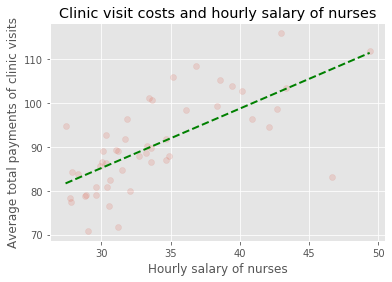

In [29]:
# Explore the relationship between interested dependent variable and independent variables
# Only "hourlySalary" and the dependent variable can be converged in Linear Least Squares successfully

plt.scatter(result['hourlySalary'],result['average_total_payments'],alpha = 0.15,marker='o')
plt.plot(np.unique(result['hourlySalary']),
         np.poly1d(np.polyfit(result['hourlySalary'],
                              result['average_total_payments'], 1))(np.unique(result['hourlySalary'])),
         color='green', linestyle="--", linewidth=2)

plt.ylabel('Average total payments of clinic visits')
plt.xlabel('Hourly salary of nurses')
plt.title('Clinic visit costs and hourly salary of nurses')
plt.savefig('figure2.png',dpi=100)

In [30]:
# Import statistics model to test the relationship of variables

import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

In [31]:
result['const'] = 1

reg = sm.OLS(endog=result['average_total_payments'], exog=result[['const','Nutrition','Obesity','Physical Activity','totalPolicy',
                                                                  'hourlySalary']],missing='drop')
type(reg)

regResults = reg.fit()

print(regResults.summary())

                              OLS Regression Results                              
Dep. Variable:     average_total_payments   R-squared:                       0.531
Model:                                OLS   Adj. R-squared:                  0.479
Method:                     Least Squares   F-statistic:                     10.19
Date:                    Tue, 12 Nov 2019   Prob (F-statistic):           1.28e-05
Time:                            02:48:12   Log-Likelihood:                -139.06
No. Observations:                      41   AIC:                             288.1
Df Residuals:                          36   BIC:                             296.7
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------